In [2]:
import os
os.environ["MXNET_CUDNN_LIB_CHECKING"] = "0"
os.environ["MXNET_CUDNN_AUTOTUNE_DEFAULT"] = "0"
import time
import random
import numpy as np
import mxnet as mx
from mxnet import  autograd, context
from mxnet.base import MXNetError
from sklearn.model_selection import train_test_split

import myModel
from image_Dictionary import ImageDict
import const
from my_Save import saveAsCSV, SaveModels
from mx_Train import myTrain
from decode.postprocessing.instance_segmentation import InstSegm
from myPlots import lossPlot, visualize_all
from iou import  get_iou

ctx=context.gpu()
mx.nd.waitall()
numberOfimages = 648

isVnir = False
imageType = "NDV"
if isVnir:
    imageType = "VNIR"

input_directory = const.images_2022
output_directory = os.path.join(const.result_2022, imageType, str(numberOfimages))
output_models= os.path.join(output_directory,"models")
result_path = os.path.join(output_directory, "result")
lossFile =   os.path.join(output_directory,"loss.csv") 
print('imageType:', imageType)

def makedir(path):
    os.makedirs(path, exist_ok=True)
    print(path)
    
for i in [output_directory, output_models, result_path]:
    makedir(i)

imageType: NDV
D:\Source\Output\Result_2022\NDV\648
D:\Source\Output\Result_2022\NDV\648\models
D:\Source\Output\Result_2022\NDV\648\result


# Function to load images and masks and Preprocessing

In [3]:

images_2022= ImageDict(const.images_2022,  False)
image_dict_2022  = images_2022.load_tif_files(imageType, numberOfimages = numberOfimages)
masks_2022 = ImageDict(const.masks_2022, True)
mask_dict_2022  = masks_2022.load_tif_files(imageType, image_dict_2022, numberOfimages = numberOfimages)
train_ids, val_ids = train_test_split(list(mask_dict_2022.keys()), test_size=0.2, random_state=42)
print(len(image_dict_2022))
print(len(mask_dict_2022))


input check: 100_LS_2022_2022_NDV.tif
input check: 115_LS_2022_2022_NDV.tif
input check: 116_LS_2022_2022_NDV.tif
input check: 117_LS_2022_2022_NDV.tif
input check: 132_LS_2022_2022_NDV.tif
input check: 147_LS_2022_2022_NDV.tif
input check: 161_LS_2022_2022_NDV.tif
input check: 162_LS_2022_2022_NDV.tif
input check: 175_LS_2022_2022_NDV.tif
input check: 176_LS_2022_2022_NDV.tif
input check: 191_LS_2022_2022_NDV.tif
input check: 2061_LS_2022_2022_NDV.tif
input check: 2062_LS_2022_2022_NDV.tif
input check: 2063_LS_2022_2022_NDV.tif
input check: 2064_LS_2022_2022_NDV.tif
input check: 2065_LS_2022_2022_NDV.tif
input check: 2066_LS_2022_2022_NDV.tif
input check: 2067_LS_2022_2022_NDV.tif
input check: 2068_LS_2022_2022_NDV.tif
input check: 2069_LS_2022_2022_NDV.tif
input check: 206_LS_2022_2022_NDV.tif
input check: 2070_LS_2022_2022_NDV.tif
input check: 2073_LS_2022_2022_NDV.tif
input check: 2074_LS_2022_2022_NDV.tif
input check: 2075_LS_2022_2022_NDV.tif
input check: 2078_LS_2022_2022_NDV.ti

In [4]:
images_2010 = ImageDict(const.images_2010, False)
testimages = 648
image_dict_2010 = images_2010.load_tif_files(imageType, numberOfimages=testimages)
output_directory_2010 = os.path.join(const.result_2010, imageType)
makedir(output_directory_2010)
print(len(image_dict_2010))


input check: 100_LS_2010_2010_NDV.tif
input check: 115_LS_2010_2010_NDV.tif
input check: 116_LS_2010_2010_NDV.tif
input check: 117_LS_2010_2010_NDV.tif
input check: 132_LS_2010_2010_NDV.tif
input check: 147_LS_2010_2010_NDV.tif
input check: 161_LS_2010_2010_NDV.tif
input check: 162_LS_2010_2010_NDV.tif
input check: 175_LS_2010_2010_NDV.tif
input check: 176_LS_2010_2010_NDV.tif
input check: 191_LS_2010_2010_NDV.tif
input check: 2061_LS_2010_2010_NDV.tif
input check: 2062_LS_2010_2010_NDV.tif
input check: 2063_LS_2010_2010_NDV.tif
input check: 2064_LS_2010_2010_NDV.tif
input check: 2065_LS_2010_2010_NDV.tif
input check: 2066_LS_2010_2010_NDV.tif
input check: 2067_LS_2010_2010_NDV.tif
input check: 2068_LS_2010_2010_NDV.tif
input check: 2069_LS_2010_2010_NDV.tif
input check: 206_LS_2010_2010_NDV.tif
input check: 2070_LS_2010_2010_NDV.tif
input check: 2073_LS_2010_2010_NDV.tif
input check: 2074_LS_2010_2010_NDV.tif
input check: 2075_LS_2010_2010_NDV.tif
input check: 2078_LS_2010_2010_NDV.ti

In [3]:
def get_images(ids, image_dict):
    data=  np.array([image_dict[id].image for id in ids])
    return mx.nd.array(data)

train_images =get_images(train_ids, image_dict_2022)
train_masks = get_images(train_ids, mask_dict_2022)
val_images = get_images(val_ids, image_dict_2022)
val_masks = get_images(val_ids, mask_dict_2022)

batch_size=4
try:
    train_dataset = mx.gluon.data.ArrayDataset(train_images, train_masks)
    train_loader = mx.gluon.data.DataLoader(train_dataset, batch_size=batch_size, num_workers=0,shuffle=True)
    val_loader = mx.gluon.data.DataLoader(mx.gluon.data.ArrayDataset(val_images, val_masks), batch_size=batch_size, num_workers=0, shuffle=False)

except Exception as e:
    print(f"Error creating data loaders: {e}")

depth:= 0, nfilters: 32, nheads::8, widths::1
depth:= 1, nfilters: 64, nheads::16, widths::1
depth:= 2, nfilters: 128, nheads::32, widths::1
depth:= 3, nfilters: 256, nheads::64, widths::1
depth:= 4, nfilters: 512, nheads::128, widths::1
depth:= 5, nfilters: 1024, nheads::256, widths::1
depth:= 6, nfilters: 512, nheads::256, widths::1
depth:= 7, nfilters: 256, nheads::128, widths::1
depth:= 8, nfilters: 128, nheads::64, widths::1
depth:= 9, nfilters: 64, nheads::32, widths::1
depth:= 10, nfilters: 32, nheads::16, widths::1
Start training now...
Epoch 0: Current Learning Rate = 0.001


Training Epoch 0:   0%|          | 0/128 [00:01<?, ?it/s]


cuDNN execution failed. Retrying... (1/5)
depth:= 0, nfilters: 32, nheads::8, widths::1
depth:= 1, nfilters: 64, nheads::16, widths::1
depth:= 2, nfilters: 128, nheads::32, widths::1
depth:= 3, nfilters: 256, nheads::64, widths::1
depth:= 4, nfilters: 512, nheads::128, widths::1
depth:= 5, nfilters: 1024, nheads::256, widths::1
depth:= 6, nfilters: 512, nheads::256, widths::1
depth:= 7, nfilters: 256, nheads::128, widths::1
depth:= 8, nfilters: 128, nheads::64, widths::1
depth:= 9, nfilters: 64, nheads::32, widths::1
depth:= 10, nfilters: 32, nheads::16, widths::1
Start training now...
Epoch 0: Current Learning Rate = 0.001


Training Epoch 0:   0%|          | 0/128 [00:00<?, ?it/s]


cuDNN execution failed. Retrying... (2/5)
depth:= 0, nfilters: 32, nheads::8, widths::1
depth:= 1, nfilters: 64, nheads::16, widths::1
depth:= 2, nfilters: 128, nheads::32, widths::1
depth:= 3, nfilters: 256, nheads::64, widths::1
depth:= 4, nfilters: 512, nheads::128, widths::1
depth:= 5, nfilters: 1024, nheads::256, widths::1
depth:= 6, nfilters: 512, nheads::256, widths::1
depth:= 7, nfilters: 256, nheads::128, widths::1
depth:= 8, nfilters: 128, nheads::64, widths::1
depth:= 9, nfilters: 64, nheads::32, widths::1
depth:= 10, nfilters: 32, nheads::16, widths::1
Start training now...
Epoch 0: Current Learning Rate = 0.001


Training Epoch 0: 100%|██████████| 128/128 [18:59<00:00,  8.90s/it]


Training Loss: 0.5522717917338014


Validation Epoch 0: 100%|██████████| 32/32 [00:34<00:00,  1.07s/it]


Validation Loss: 0.5022677425295115
****************************************************************
Epoch 1: Current Learning Rate = 0.001


Training Epoch 1: 100%|██████████| 128/128 [20:02<00:00,  9.40s/it]


Training Loss: 0.49841769272461534


Validation Epoch 1: 100%|██████████| 32/32 [00:43<00:00,  1.36s/it]


Validation Loss: 0.501940593123436
****************************************************************
Epoch 2: Current Learning Rate = 0.001


Training Epoch 2: 100%|██████████| 128/128 [18:54<00:00,  8.87s/it]


Training Loss: 0.48661842569708824


Validation Epoch 2: 100%|██████████| 32/32 [00:39<00:00,  1.24s/it]


Validation Loss: 0.47811602614820004
****************************************************************
Epoch 3: Current Learning Rate = 0.001


Training Epoch 3: 100%|██████████| 128/128 [18:57<00:00,  8.89s/it]


Training Loss: 0.47866823989897966


Validation Epoch 3: 100%|██████████| 32/32 [00:31<00:00,  1.02it/s]


Validation Loss: 0.4742282582446933
****************************************************************
Epoch 4: Current Learning Rate = 0.001


Training Epoch 4: 100%|██████████| 128/128 [18:57<00:00,  8.89s/it]


Training Loss: 0.47540995804592967


Validation Epoch 4: 100%|██████████| 32/32 [00:28<00:00,  1.13it/s]


Validation Loss: 0.47062119096517563
****************************************************************
Epoch 5: Current Learning Rate = 0.001


Training Epoch 5: 100%|██████████| 128/128 [17:53<00:00,  8.39s/it]


Training Loss: 0.47236273204907775


Validation Epoch 5: 100%|██████████| 32/32 [00:38<00:00,  1.20s/it]


Validation Loss: 0.47019892651587725
****************************************************************
Epoch 6: Current Learning Rate = 0.001


Training Epoch 6: 100%|██████████| 128/128 [17:27<00:00,  8.18s/it]


Training Loss: 0.47060387511737645


Validation Epoch 6: 100%|██████████| 32/32 [00:18<00:00,  1.69it/s]


Validation Loss: 0.47480535320937634
****************************************************************
Epoch 7: Current Learning Rate = 0.001


Training Epoch 7: 100%|██████████| 128/128 [17:20<00:00,  8.13s/it]


Training Loss: 0.47000867733731866


Validation Epoch 7: 100%|██████████| 32/32 [00:29<00:00,  1.07it/s]


Validation Loss: 0.47053663339465857
****************************************************************
Epoch 8: Current Learning Rate = 0.001


Training Epoch 8: 100%|██████████| 128/128 [17:44<00:00,  8.32s/it]


Training Loss: 0.46902147377841175


Validation Epoch 8: 100%|██████████| 32/32 [00:29<00:00,  1.10it/s]


Validation Loss: 0.46728251688182354
****************************************************************
Epoch 9: Current Learning Rate = 0.001


Training Epoch 9: 100%|██████████| 128/128 [17:53<00:00,  8.38s/it]


Training Loss: 0.46784681803546846


Validation Epoch 9: 100%|██████████| 32/32 [00:25<00:00,  1.24it/s]


Validation Loss: 0.4665767699480057
****************************************************************
Epoch 10: Current Learning Rate = 0.001


Training Epoch 10: 100%|██████████| 128/128 [15:29<00:00,  7.26s/it]


Training Loss: 0.4674780569039285


Validation Epoch 10: 100%|██████████| 32/32 [00:16<00:00,  1.98it/s]


Validation Loss: 0.4680959973484278
****************************************************************
Epoch 11: Current Learning Rate = 0.001


Training Epoch 11: 100%|██████████| 128/128 [13:21<00:00,  6.26s/it]


Training Loss: 0.46611772989854217


Validation Epoch 11: 100%|██████████| 32/32 [00:18<00:00,  1.75it/s]


Validation Loss: 0.46472553350031376
****************************************************************
Epoch 12: Current Learning Rate = 0.001


Training Epoch 12: 100%|██████████| 128/128 [13:22<00:00,  6.27s/it]


Training Loss: 0.4652689518406987


Validation Epoch 12: 100%|██████████| 32/32 [00:16<00:00,  1.95it/s]


Validation Loss: 0.46597144193947315
****************************************************************
Epoch 13: Current Learning Rate = 0.001


Training Epoch 13: 100%|██████████| 128/128 [13:32<00:00,  6.35s/it]


Training Loss: 0.4654514850117266


Validation Epoch 13: 100%|██████████| 32/32 [00:17<00:00,  1.79it/s]


Validation Loss: 0.4641829440370202
****************************************************************
Epoch 14: Current Learning Rate = 0.001


Training Epoch 14: 100%|██████████| 128/128 [13:25<00:00,  6.29s/it]


Training Loss: 0.4643954047933221


Validation Epoch 14: 100%|██████████| 32/32 [00:16<00:00,  1.98it/s]


Validation Loss: 0.46623567398637533
****************************************************************
Epoch 15: Current Learning Rate = 0.001


Training Epoch 15: 100%|██████████| 128/128 [13:22<00:00,  6.27s/it]


Training Loss: 0.4641879617702216


Validation Epoch 15: 100%|██████████| 32/32 [00:17<00:00,  1.79it/s]


Validation Loss: 0.46440856344997883
****************************************************************
Epoch 16: Current Learning Rate = 0.001


Training Epoch 16: 100%|██████████| 128/128 [13:15<00:00,  6.22s/it]


Training Loss: 0.4636086015962064


Validation Epoch 16: 100%|██████████| 32/32 [00:16<00:00,  1.98it/s]


Validation Loss: 0.46231484692543745
****************************************************************
Epoch 17: Current Learning Rate = 0.001


Training Epoch 17: 100%|██████████| 128/128 [13:07<00:00,  6.16s/it]


Training Loss: 0.4635889439377934


Validation Epoch 17: 100%|██████████| 32/32 [00:18<00:00,  1.78it/s]


Validation Loss: 0.46787549648433924
****************************************************************
Epoch 18: Current Learning Rate = 0.001


Training Epoch 18: 100%|██████████| 128/128 [12:48<00:00,  6.00s/it]


Training Loss: 0.46292526740580797


Validation Epoch 18: 100%|██████████| 32/32 [00:16<00:00,  1.98it/s]


Validation Loss: 0.4621574468910694
****************************************************************
Epoch 19: Current Learning Rate = 0.001


Training Epoch 19: 100%|██████████| 128/128 [12:50<00:00,  6.02s/it]


Training Loss: 0.4625285111833364


Validation Epoch 19: 100%|██████████| 32/32 [00:16<00:00,  1.98it/s]


Validation Loss: 0.46228406112641096
****************************************************************
Epoch 20: Current Learning Rate = 0.001


Training Epoch 20: 100%|██████████| 128/128 [13:28<00:00,  6.31s/it]


Training Loss: 0.4617988718673587


Validation Epoch 20: 100%|██████████| 32/32 [00:18<00:00,  1.70it/s]


Validation Loss: 0.4663946498185396
****************************************************************
Epoch 21: Current Learning Rate = 0.001


Training Epoch 21: 100%|██████████| 128/128 [13:32<00:00,  6.35s/it]


Training Loss: 0.4619079085532576


Validation Epoch 21: 100%|██████████| 32/32 [00:16<00:00,  1.95it/s]


Validation Loss: 0.4650696739554405
Reducing learning rate to 0.0005
****************************************************************
Epoch 22: Current Learning Rate = 0.0005


Training Epoch 22: 100%|██████████| 128/128 [14:36<00:00,  6.85s/it]


Training Loss: 0.45954736275598407


Validation Epoch 22: 100%|██████████| 32/32 [00:18<00:00,  1.75it/s]


Validation Loss: 0.4592015817761421
****************************************************************
Epoch 23: Current Learning Rate = 0.0005


Training Epoch 23: 100%|██████████| 128/128 [14:42<00:00,  6.90s/it]


Training Loss: 0.4600296332500875


Validation Epoch 23: 100%|██████████| 32/32 [00:16<00:00,  1.92it/s]


Validation Loss: 0.45886577013880014
****************************************************************
Epoch 24: Current Learning Rate = 0.0005


Training Epoch 24: 100%|██████████| 128/128 [15:03<00:00,  7.06s/it]


Training Loss: 0.4591007037088275


Validation Epoch 24: 100%|██████████| 32/32 [00:33<00:00,  1.05s/it]


Validation Loss: 0.4596388041973114
****************************************************************
Epoch 25: Current Learning Rate = 0.0005


Training Epoch 25: 100%|██████████| 128/128 [14:40<00:00,  6.88s/it]


Training Loss: 0.4587362795136869


Validation Epoch 25: 100%|██████████| 32/32 [00:18<00:00,  1.70it/s]


Validation Loss: 0.4609982343390584
****************************************************************
Epoch 26: Current Learning Rate = 0.0005


Training Epoch 26: 100%|██████████| 128/128 [15:25<00:00,  7.23s/it]


Training Loss: 0.458531467942521


Validation Epoch 26: 100%|██████████| 32/32 [00:16<00:00,  1.92it/s]


Validation Loss: 0.4590803887695074
Reducing learning rate to 0.00025
****************************************************************
Epoch 27: Current Learning Rate = 0.00025


Training Epoch 27: 100%|██████████| 128/128 [14:51<00:00,  6.97s/it]


Training Loss: 0.45789202162995934


Validation Epoch 27: 100%|██████████| 32/32 [00:20<00:00,  1.55it/s]


Validation Loss: 0.45811209082603455
****************************************************************
Epoch 28: Current Learning Rate = 0.00025


Training Epoch 28: 100%|██████████| 128/128 [15:38<00:00,  7.33s/it]


Training Loss: 0.4570913282223046


Validation Epoch 28: 100%|██████████| 32/32 [00:18<00:00,  1.72it/s]


Validation Loss: 0.4587858347222209
****************************************************************
Epoch 29: Current Learning Rate = 0.00025


Training Epoch 29: 100%|██████████| 128/128 [14:46<00:00,  6.92s/it]


Training Loss: 0.4568217338528484


Validation Epoch 29: 100%|██████████| 32/32 [00:18<00:00,  1.74it/s]


Validation Loss: 0.4585023671388626
****************************************************************
Epoch 30: Current Learning Rate = 0.00025


Training Epoch 30: 100%|██████████| 128/128 [14:49<00:00,  6.95s/it]


Training Loss: 0.45675778831355274


Validation Epoch 30: 100%|██████████| 32/32 [00:16<00:00,  1.92it/s]


Validation Loss: 0.459316392429173
Reducing learning rate to 0.000125
****************************************************************
Epoch 31: Current Learning Rate = 0.000125


Training Epoch 31: 100%|██████████| 128/128 [14:17<00:00,  6.70s/it]


Training Loss: 0.45566677674651146


Validation Epoch 31: 100%|██████████| 32/32 [00:16<00:00,  1.92it/s]


Validation Loss: 0.4571934510022402
****************************************************************
Epoch 32: Current Learning Rate = 0.000125


Training Epoch 32: 100%|██████████| 128/128 [14:52<00:00,  6.98s/it]


Training Loss: 0.45580609678290784


Validation Epoch 32: 100%|██████████| 32/32 [00:18<00:00,  1.73it/s]


Validation Loss: 0.45855431724339724
****************************************************************
Epoch 33: Current Learning Rate = 0.000125


Training Epoch 33: 100%|██████████| 128/128 [14:42<00:00,  6.90s/it]


Training Loss: 0.4554062676616013


Validation Epoch 33: 100%|██████████| 32/32 [00:29<00:00,  1.07it/s]


Validation Loss: 0.45770894177258015
****************************************************************
Epoch 34: Current Learning Rate = 0.000125


Training Epoch 34: 100%|██████████| 128/128 [14:58<00:00,  7.02s/it]


Training Loss: 0.4549832169432193


Validation Epoch 34: 100%|██████████| 32/32 [00:22<00:00,  1.44it/s]


Validation Loss: 0.45877702720463276
Reducing learning rate to 6.25e-05
****************************************************************
Epoch 35: Current Learning Rate = 6.25e-05


Training Epoch 35: 100%|██████████| 128/128 [15:07<00:00,  7.09s/it]


Training Loss: 0.45463597984053195


Validation Epoch 35: 100%|██████████| 32/32 [00:16<00:00,  1.92it/s]


Validation Loss: 0.45752971805632114
****************************************************************
Epoch 36: Current Learning Rate = 6.25e-05


Training Epoch 36: 100%|██████████| 128/128 [14:38<00:00,  6.86s/it]


Training Loss: 0.4541158094070852


Validation Epoch 36: 100%|██████████| 32/32 [00:16<00:00,  1.91it/s]


Validation Loss: 0.457706144079566
****************************************************************
Epoch 37: Current Learning Rate = 6.25e-05


Training Epoch 37: 100%|██████████| 128/128 [15:25<00:00,  7.23s/it]


Training Loss: 0.4543305393308401


Validation Epoch 37: 100%|██████████| 32/32 [00:18<00:00,  1.72it/s]


Validation Loss: 0.45992257725447416
Reducing learning rate to 3.125e-05
****************************************************************
Epoch 38: Current Learning Rate = 3.125e-05


Training Epoch 38: 100%|██████████| 128/128 [15:09<00:00,  7.11s/it]


Training Loss: 0.45370790059678257


Validation Epoch 38: 100%|██████████| 32/32 [00:19<00:00,  1.66it/s]


Validation Loss: 0.45891683641821146
****************************************************************
Epoch 39: Current Learning Rate = 3.125e-05


Training Epoch 39: 100%|██████████| 128/128 [14:50<00:00,  6.96s/it]


Training Loss: 0.4535580277442932


Validation Epoch 39: 100%|██████████| 32/32 [00:19<00:00,  1.66it/s]


Validation Loss: 0.45805111806839705
****************************************************************
Epoch 40: Current Learning Rate = 3.125e-05


Training Epoch 40: 100%|██████████| 128/128 [15:03<00:00,  7.06s/it]


Training Loss: 0.45329415681771934


Validation Epoch 40: 100%|██████████| 32/32 [00:18<00:00,  1.74it/s]


Validation Loss: 0.45826653204858303
Reducing learning rate to 1.5625e-05
****************************************************************
Epoch 41: Current Learning Rate = 1.5625e-05


Training Epoch 41: 100%|██████████| 128/128 [14:56<00:00,  7.01s/it]


Training Loss: 0.4534942707978189


Validation Epoch 41: 100%|██████████| 32/32 [00:21<00:00,  1.50it/s]


Validation Loss: 0.4577223267406225
Early stopping triggered
Data saved to D:\Source\Output\Result_2022\NDV\648\loss.csv
Index(['Current Epoch', 'Training Loss', 'Validation Loss'], dtype='object')


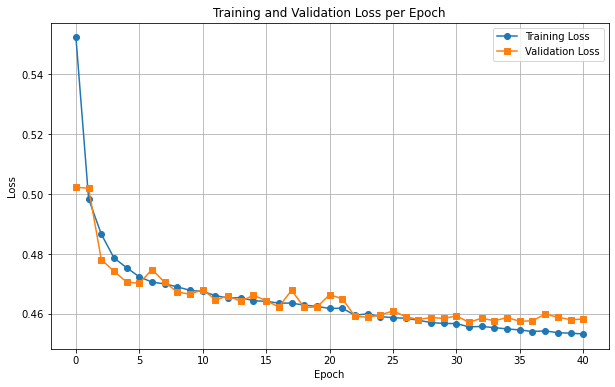

In [4]:
# Maximum number of retries
max_retries = 5
retry_count = 0

# Retry logic
while retry_count < max_retries:
    try:
        mxTn = myTrain(train_loader, val_loader)
        loss_each_epoch, model_list, epoch = mxTn.train(ctx, epochs = 50)
        saveAsCSV(["Current Epoch", "Training Loss", "Validation Loss"], lossFile, loss_each_epoch)
        SaveModels(output_models, model_list)
        lossPlot(loss_each_epoch, output_directory)
        break
    except MXNetError  as e:
        if 'CUDNN_STATUS_EXECUTION_FAILED' in str(e):
            print(f"cuDNN execution failed. Retrying... ({retry_count + 1}/{max_retries})")
            mx.nd.waitall()  # Clear GPU memory
            time.sleep(5) # Wait for a few seconds before retrying
            retry_count += 1 # Increment the retry counter
        else:
            raise  # If it's another error, raise it

# Check if maximum retries were reached
if retry_count == max_retries:
    print("Maximum retries reached. Training failed due to cuDNN error.")

In [19]:
def get_model_file_name():
    files = os.listdir(output_models)  # Get all files in the folder
    if files:
        last_file = os.path.join(output_models, f'model_VNIR_{len(files)-1}.params')
        print(f"This model is using: {last_file}")
        return last_file
    else:
        print("The folder is empty.")

def get_img_metadata(id, is2022):
    if is2022:
        print('Helo')
        img = images_2022.getImage(id, image_dict_2022, ctx)
        currentMetadata = image_dict_2022[id]
    else:
        img = images_2010.getImage(id, image_dict_2010, ctx)
        currentMetadata = image_dict_2010[id]
    return img, currentMetadata

def get_ref_path(is2022):
    ref_path = const.output_ref_2022    
    if not is2022:
        ref_path = const.output_ref_2010
    return ref_path

def visualize_predictions(result_path, val_ids, t_ext , t_bound , is2022):    
    print(f"Starting visualization with t_ext = {t_ext}, t_bound = {t_bound}")
    modelPath = rf"{get_model_file_name()}"
    ref_path = get_ref_path(is2022)   

    netPredict = myModel.MyFractalResUNetcmtsk(True, modelPath, ctx)
    ious=[]

    for id in val_ids:  # Limit to 'num_images' for visualization
        print(f"Processing image ID: {id}")
        try:
            img, currentMetadata = get_img_metadata(id, is2022)

            with autograd.predict_mode():  
                outputs = netPredict.net(img) 
                pred_segm  = np.array(outputs[0][0,1,:,:].asnumpy())
                pred_bound =  np.array(outputs[1][0,1,:,:].asnumpy())
                pred_segm = 1-pred_segm
  
                print("Shape of pred_segm:", pred_segm.shape, "Shape of pred_bound:", pred_bound.shape, "Shape of binary_extent_mask:", pred_segm.shape)
                print("NaNs in pred_segm:", np.isnan(pred_segm).sum(), "NaNs in binary_extent_mask:", np.isnan(pred_segm).sum())

                inst =InstSegm(pred_segm, pred_bound, t_ext=t_ext, t_bound=t_bound)   # perform instance segmentation
                print("NaNs in inst:", np.isnan(inst).sum())
                inst = np.nan_to_num(inst, nan=0)
                output_shapefile_path = visualize_all(id, img, currentMetadata, outputs, pred_segm, pred_bound, inst, result_path)

                print("Start IOU calculation")
                csv_file_path = os.path.join(result_path, str(id), "iou.csv")
                iou_score= get_iou(os.path.join(ref_path, f'tile_{id}.shp'), os.path.join(output_shapefile_path, f'{str(id)}.shp'))

                ious.append({ "ID": id,"IOU": iou_score })
                ious.append({"ID": f't_ext: {t_ext}',"IOU": f't_bound: {t_bound}'}) 
                saveAsCSV(["ID", "IOU"], csv_file_path, ious, True)

        except Exception as e:
            print(f"Error processing image ID {id}: {e}")
       
def visualize(result_path, val_ids,  t_ext , t_bound , is2022 = True):
    random_val_ids = random.choice(val_ids) # Choose a random validation ID
    visualize_predictions(result_path, [random_val_ids],t_ext = t_ext, t_bound = t_bound, is2022 = is2022)
    print("Visualization completed successfully.")
 


In [16]:
print(val_ids)
print(2085 in val_ids)
print(2085 in image_dict_2022.keys())

[453, 6705, 6924, 6564, 6980, 69, 2086, 6892, 6555, 6588, 191, 6869, 6664, 6946, 6876, 6674, 6609, 6874, 6686, 470, 5467, 6934, 6925, 6950, 6783, 3806, 5299, 6833, 6908, 3782, 6612, 3701, 6572, 6648, 6611, 6764, 116, 6643, 6683, 6786, 3771, 5509, 6567, 2085, 6656, 6849, 6750, 6630, 6586, 5466, 6988, 6936, 6708, 284, 6626, 6560, 6641, 6693, 6563, 6642, 3874, 6616, 3829, 6688, 348, 3862, 6761, 243, 6517, 5514, 161, 5412, 416, 6507, 514, 6654, 5476, 6529, 6790, 6947, 6629, 6551, 263, 6800, 6561, 371, 6778, 6515, 6613, 6544, 6684, 2075, 6989, 6526, 6967, 433, 6636, 6817, 3873, 6864, 3816, 6734, 84, 5298, 6846, 3733, 6707, 6533, 6780, 6587, 6962, 6620, 6759, 6785, 6716, 6951, 6579, 6687, 6788, 2084, 6835, 5465, 6565, 6777, 6596, 6600, 6721, 6782]
True
True


# Applying model in 2022 images

Starting visualization with t_ext = 0.6, t_bound = 0.1
This model is using: D:\Source\Output\Result_2022\NDV\648\models\model_VNIR_40.params
depth:= 0, nfilters: 32, nheads::8, widths::1
depth:= 1, nfilters: 64, nheads::16, widths::1
depth:= 2, nfilters: 128, nheads::32, widths::1
depth:= 3, nfilters: 256, nheads::64, widths::1
depth:= 4, nfilters: 512, nheads::128, widths::1
depth:= 5, nfilters: 1024, nheads::256, widths::1
depth:= 6, nfilters: 512, nheads::256, widths::1
depth:= 7, nfilters: 256, nheads::128, widths::1
depth:= 8, nfilters: 128, nheads::64, widths::1
depth:= 9, nfilters: 64, nheads::32, widths::1
depth:= 10, nfilters: 32, nheads::16, widths::1
Processing image ID: 161
Helo
Shape of pred_segm: (256, 256) Shape of pred_bound: (256, 256) Shape of binary_extent_mask: (256, 256)
NaNs in pred_segm: 0 NaNs in binary_extent_mask: 0
NaNs in inst: 31515
Saved polygons to D:\Source\Output\Result_2022\NDV\648\result\161


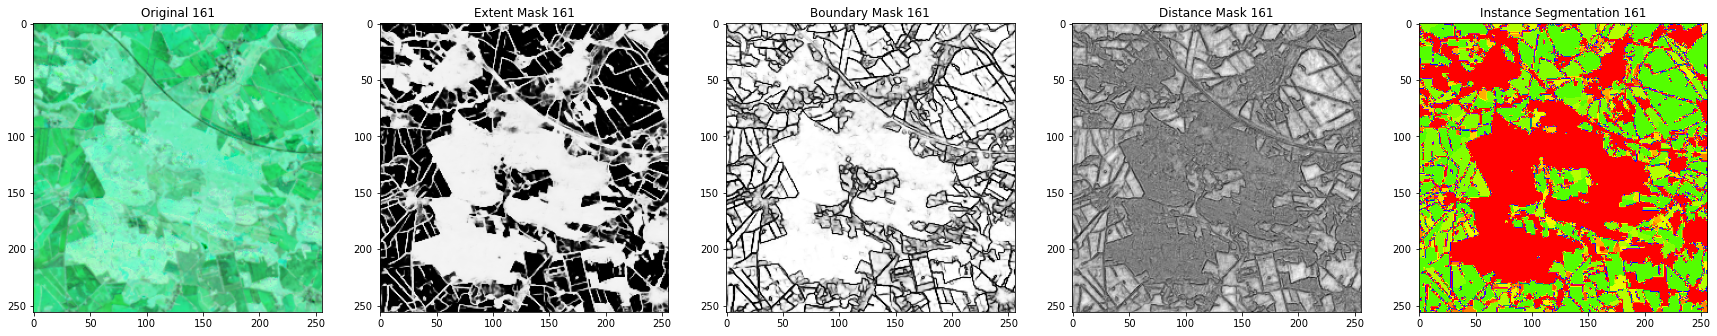

Complete plotting 161
Start IOU calculation
IoU: 0.1585
Data saved to D:\Source\Output\Result_2022\NDV\648\result\161\iou.csv
Visualization completed successfully.


In [22]:
#This is for vnir: t_ext = 0.6, t_bound = 0.1
visualize(result_path, val_ids, t_ext = 0.6, t_bound = 0.1, is2022 = True)

# Applying model in 2010 images

In [ ]:
#list(image_2010_dict.keys())
visualize(output_directory_2010, list(image_dict_2010.keys()),  t_ext = 0.6, t_bound = 0.1, is2022= False)